# Confidence model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
from rdkit import Chem


# Sci-kit learn
from mol2ccs.confidence_model import RFStructureConfidenceModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (
    recall_score,
    precision_score,
    f1_score,
    accuracy_score,
    roc_auc_score,
)

from utils import SeabornFig2Grid
import matplotlib.gridspec as gridspec

from scipy.stats import linregress
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
warnings.simplefilter(action="ignore", category=FutureWarning)

# SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# Get data

In [4]:
ccsbase_full = pd.read_parquet(
    "/ccs-prediction/ccsbase_3d.parquet",
)


metlin_full = pd.read_parquet(
    "/ccs-prediction/metlin_3d.parquet",
)

In [5]:
metlin_test = pd.read_parquet("/ccs-prediction/metlin_test_3d.parquet")
ccsbase_test = pd.read_parquet("/ccs-prediction/ccsbase_test_3d.parquet")

original_test_sets = {
    "ccsbase": ccsbase_test,
    "metlin": metlin_test,
}

In [6]:
relevant_cols = [
    "dimer",
    "source",
    "mol_type",
    "ccs_type",
    "drugtax",
    "type_dimer",
    "smiles_adduct",
]

metlin_full = metlin_full[relevant_cols]
ccsbase_full = ccsbase_full[relevant_cols]

In [7]:
predictions = {}

# Load the original test sets for each dataset
original_test_set_preds = dict(
    zip(
        [
            "ccsbase test",
            "metlin test",
        ],
        [
            "/ccs-prediction-outputs/final-experiments-paper/mol2ccs/ccsbase_test_3d_pred.parquet",  # 0.05% error is necessary because the model is pretty good
            "/ccs-prediction-outputs/final-experiments-paper/mol2ccs/metlin_test_3d_pred.parquet",
        ],
    )
)


# Load the predictions for the models trained on the other dataset
for name, path in zip(
    [
        "ccsbase predictions from metlin",
        "metlin predictions from ccsbase",
    ],
    [
        "/ccs-prediction-outputs/final-experiments-paper/mol2ccs/ccsbase_3d_pred.parquet",  # 5% error -> good
        "/ccs-prediction-outputs/final-experiments-paper/mol2ccs/metlin_3d_pred.parquet",  # 5% error -> good
    ],
):
    preds = pd.read_parquet(path)

    # Get all molecular information
    preds["smiles_adduct"] = preds["smiles"] + "_" + preds["adduct"]
    if "ccsbase" in path:
        preds = preds.merge(ccsbase_full, on="smiles_adduct", how="left")
    else:
        preds = preds.merge(metlin_full, on="smiles_adduct", how="left")

    # Split the data into train, test, and validation
    original_test_set = original_test_sets[name.split(" ")[0]]
    test = preds[preds.smiles_adduct.isin(list(original_test_set.smiles_adduct))]
    train = preds[~preds.smiles_adduct.isin(list(test.smiles_adduct))]
    train_smiles = train.smiles.unique()
    train_smiles, val_smiles = train_test_split(
        train_smiles, test_size=0.1, random_state=42
    )
    val = train[train.smiles.isin(val_smiles)]
    train = train[train.smiles.isin(train_smiles)]

    # ensure that no smiles are in both train and test
    assert len(set(train.smiles).intersection(set(test.smiles))) == 0
    assert len(set(val.smiles).intersection(set(test.smiles))) == 0
    assert len(set(train.smiles).intersection(set(val.smiles))) == 0

    predictions[name] = {
        "train": train,
        "test": test,
        "val": val,
    }

# Get model

In [8]:
all_confidence_preds = {}
all_confidence_preds_val = {}
all_models_dict = {}
num_samples = [0]

# train models for each dataset
for num_sample in num_samples:
    confidence_preds = {}
    models_dict = {}
    confidence_preds_val = {}
    for prediction_file in tqdm(predictions):
        print(f"Training model for {prediction_file}")

        # Get test set and in-domain training set
        test = predictions[prediction_file]["test"]
        val = predictions[prediction_file]["val"]
        in_domain_train = predictions[prediction_file]["train"]

        # Sample from in domain training set
        train = in_domain_train.copy()

        error_threshold = 0.05  # 5% error

        # initialize model
        model = RFStructureConfidenceModel(
            estimator_type="classifier",
            target_type="binary_error",
        )

        # fit model
        model.fit(
            train,
            hpo_params={
                "n_estimators": [50, 100, 200, 400],
                "max_depth": [None, 10, 20, 50],
                "min_samples_split": [2, 5, 20],
            },
            error_threshold=error_threshold,
        )

        # predict confidence
        test["confs"] = model.predict_confidence(test)

        # calculate errors
        test["errors"] = abs(test["ccs"] - test["pred_ccs"])

        # predict confidence on validation set
        val["confs"] = model.predict_confidence(val)
        val["errors"] = abs(val["ccs"] - val["pred_ccs"])

        # save predictions
        confidence_preds[prediction_file] = test.copy()
        confidence_preds_val[prediction_file] = val.copy()
        models_dict[prediction_file] = model

    all_confidence_preds[num_sample] = confidence_preds
    all_confidence_preds_val[num_sample] = confidence_preds_val
    all_models_dict[num_sample] = models_dict

  0%|          | 0/2 [00:00<?, ?it/s]

Training model for ccsbase predictions from metlin

            Number of labels: False    4502
True     3539
Name: count, dtype: int64
            % of True labels: 44.01%
            % of False labels: 55.99%
            


/Users/chloeengler/Documents/Tools/ccs-prediction/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
 50%|█████     | 1/2 [00:23<00:23, 23.04s/it]

Training model for metlin predictions from ccsbase

            Number of labels: True     34644
False    11499
Name: count, dtype: int64
            % of True labels: 75.08%
            % of False labels: 24.92%
            


/Users/chloeengler/Documents/Tools/ccs-prediction/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
100%|██████████| 2/2 [02:30<00:00, 75.07s/it]


# Get thresholds

In [9]:
#  Iterate through the predictions again and calculate precision and recall for the different thresholds

all_cutoffs_val = {}

# Get the precision and recall for each threshold
for num_sample in num_samples:
    cutoffs = defaultdict(dict)
    for prediction_file in all_confidence_preds_val[num_sample]:
        if "from" not in prediction_file:
            print(f"Skipping {prediction_file} because preds are not good")
            continue

        # Get the predictions
        prediction_df = all_confidence_preds_val[num_sample][prediction_file]

        # Iterate through the thresholds
        for threshold in range(0, 10, 1):
            threshold /= 10

            # if y is less than 5% of the true CCS, set to True, else False
            y = prediction_df["ccs"] - prediction_df["pred_ccs"]
            y = y.abs()
            labels = y < (error_threshold * prediction_df["ccs"])

            # determine if confidence is greater than threshold
            pred_labels = prediction_df["confs"] >= threshold

            # change labels and pred_labels to 0 and 1 from True and False
            labels = labels.astype(int)
            pred_labels = pred_labels.astype(int)

            # calculate precision and recall
            precision = precision_score(labels, pred_labels)
            recall = recall_score(labels, pred_labels)
            f1 = f1_score(labels, pred_labels)
            accuracy = accuracy_score(labels, pred_labels)
            auc_roc = roc_auc_score(labels, pred_labels)
            dataset_percentage = (pred_labels == 1).mean()

            # save results
            cutoffs[prediction_file][threshold] = {
                "precision": precision,
                "recall": recall,
                "f1": f1,
                "accuracy": accuracy,
                "auc_roc": auc_roc,
                "labels": labels,
                "pred_labels": pred_labels,
                "dataset_percentage": dataset_percentage,
            }

    all_cutoffs_val[num_sample] = cutoffs

In [10]:
all_thresholds_df = {}

# Get the threshold where recall is greater than precision
for num_sample in num_samples:
    threshold_df = {}
    for i, prediction_file in enumerate(all_cutoffs_val[num_sample]):

        # Get the cutoffs
        cutoffs_df = pd.DataFrame(all_cutoffs_val[num_sample][prediction_file]).T.iloc[
            1:
        ]

        # Get last cutoff where recall is > than precision
        cutoffs_df["recall_precision_diff"] = (
            cutoffs_df["recall"] - cutoffs_df["precision"]
        )
        current_threshold = cutoffs_df[cutoffs_df["recall_precision_diff"] <= 0].index[
            0
        ]
        current_threshold = current_threshold - 0.1
        threshold_df[prediction_file] = current_threshold

    all_thresholds_df[num_sample] = threshold_df

# Look at distributions of conf scores

In [11]:
name_style = {
    "ccsbase predictions from metlin": "METLIN-CCS (train) CCSBase (test)",
    "metlin predictions from ccsbase": "CCSBase (train) METLIN-CCS (test)",
}

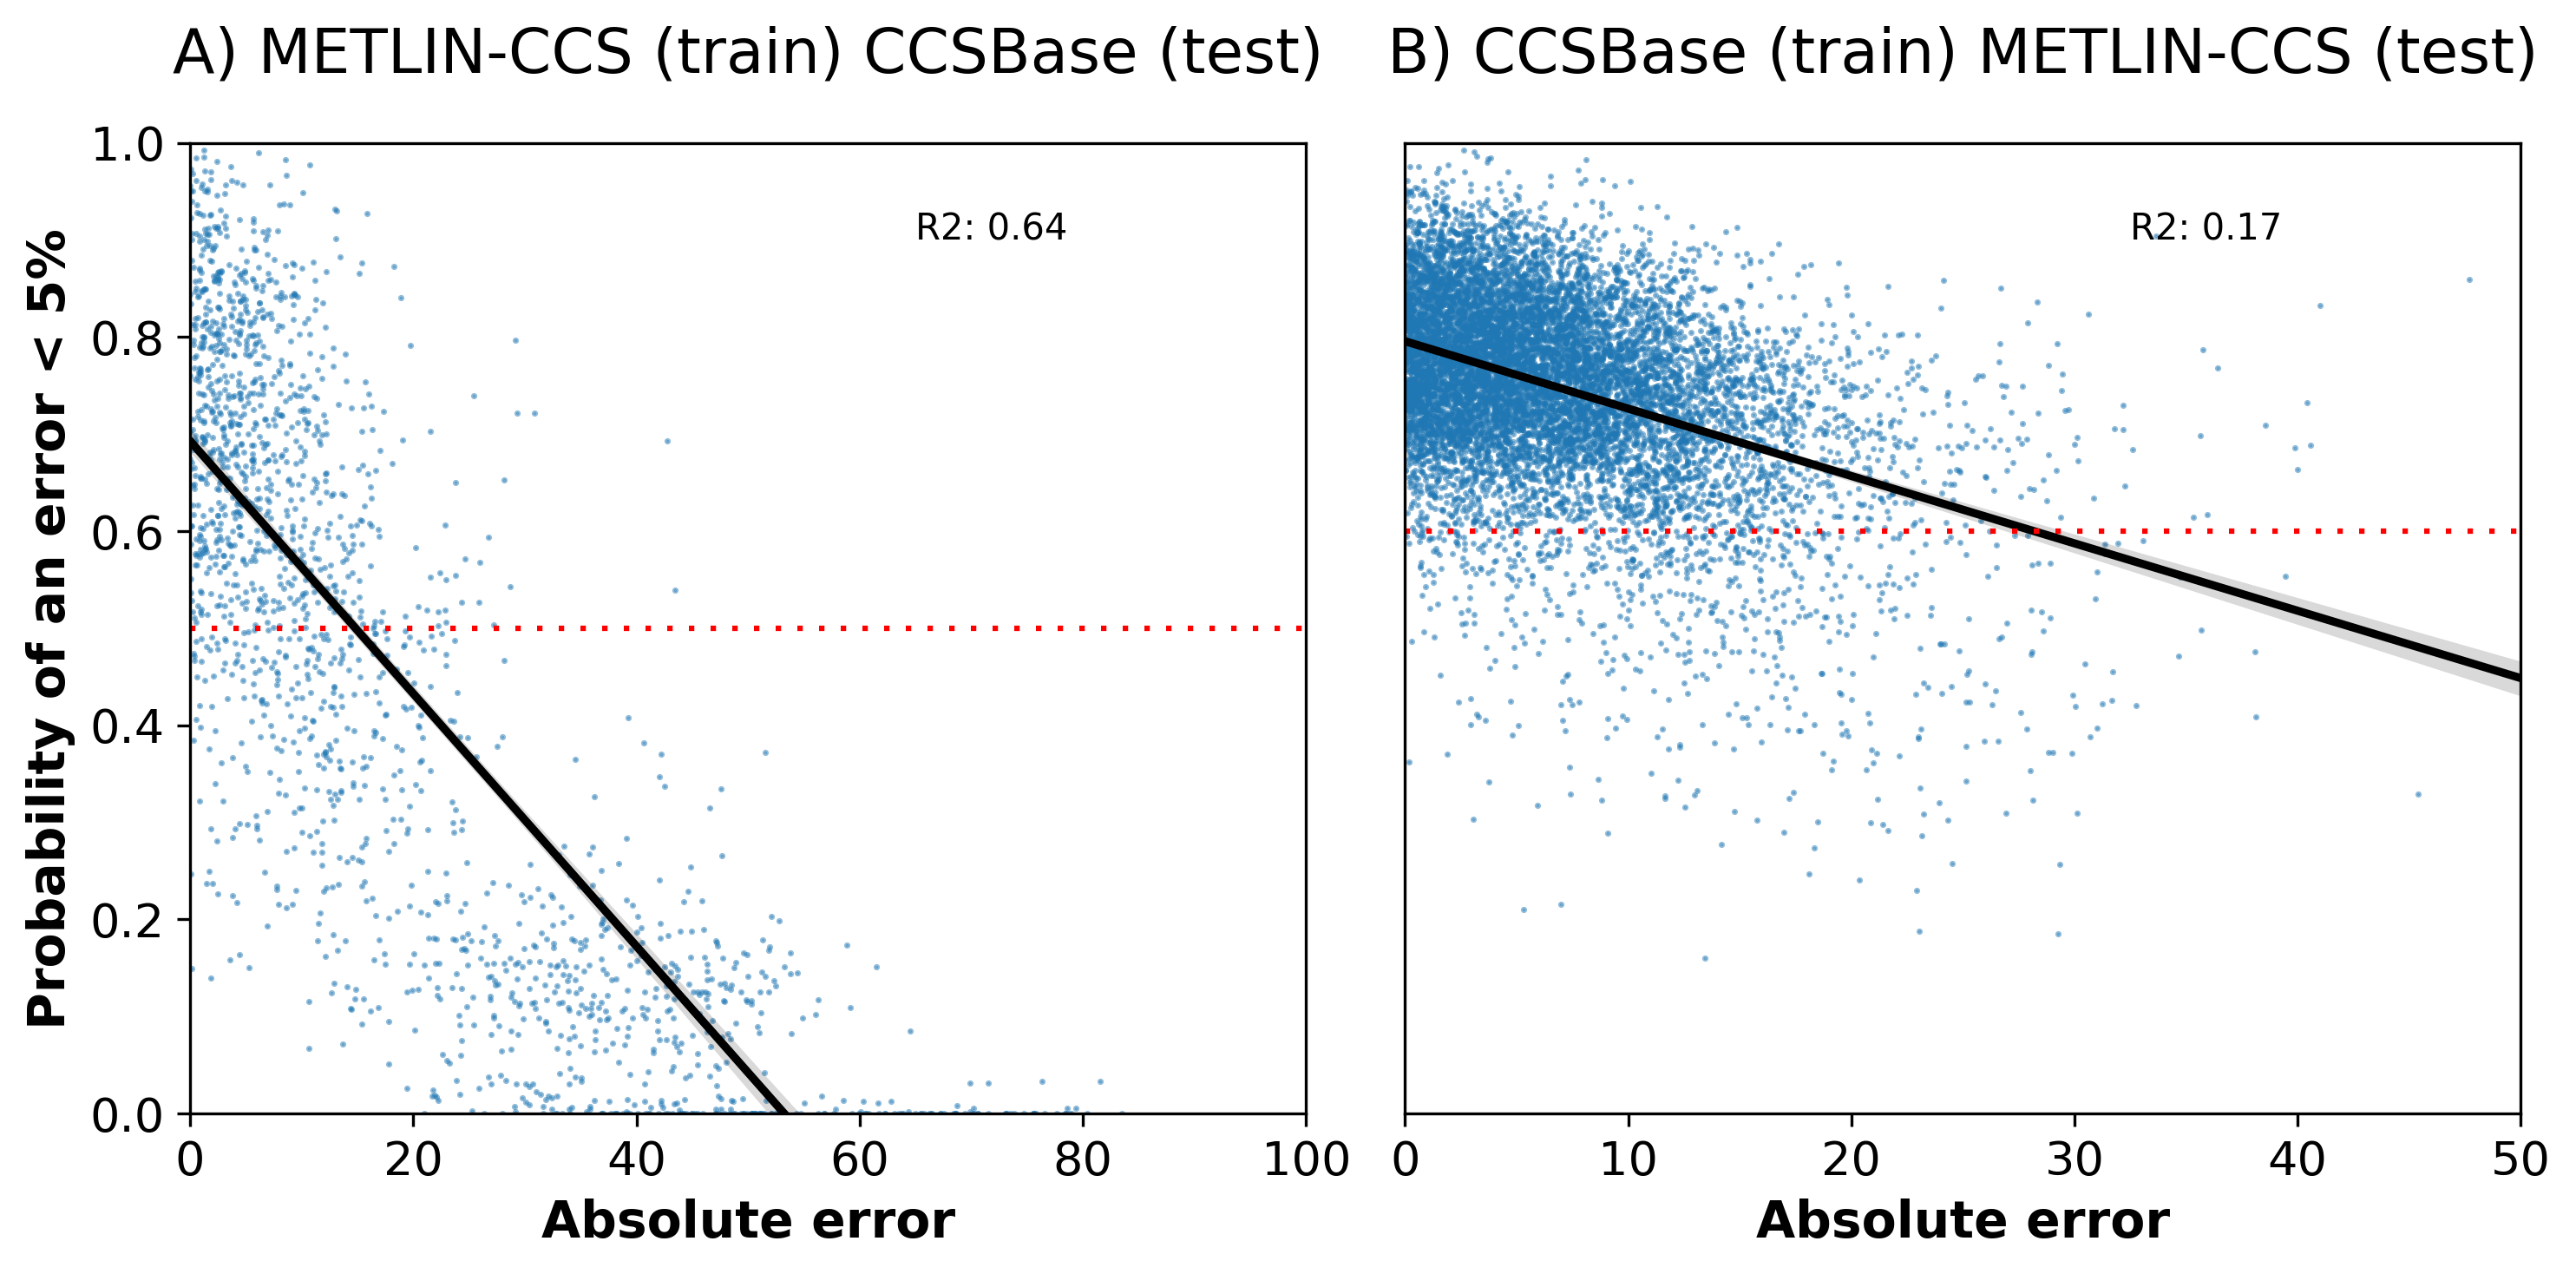

In [12]:
# Make a 2x2 plot of the results with a regression line


for sample_size in all_confidence_preds:

    fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
    for i, prediction_file in enumerate(all_confidence_preds[sample_size]):
        prediction_df = all_confidence_preds[sample_size][prediction_file]

        size_factor = 0.5

        # regression plot
        sns.regplot(
            x="errors",
            y="confs",
            data=prediction_df,
            scatter_kws={"s": size_factor, "alpha": 0.5},
            line_kws={"color": "black"},
            ax=axs[i],
        )

        if i == 0:
            title = f"A) {name_style[prediction_file]}"
        else:
            title = f"B) {name_style[prediction_file]}"

        axs[i].set_title(title, fontsize=17, y=1.05)
        axs[i].set_xlabel("Absolute error", fontsize=14, fontweight="bold")

        # show only if it's the first column
        if i % 2 == 0:
            axs[i].set_ylabel(
                "Probability of an error < 5%", fontweight="bold", fontsize=14
            )
        else:
            axs[i].set_ylabel("")
            axs[i].set_yticks([])

        # Axes limits
        if "test" in prediction_file:
            axs[i].set_xlim(0, 40)

        elif "ccsbase predictions from metlin" in prediction_file:
            axs[i].set_xlim(0, 100)
        else:
            axs[i].set_xlim(0, 50)

        # larger ticks x and y
        axs[i].tick_params(axis="both", which="major", labelsize=13)

        # calculate r2 and plot it
        r2 = prediction_df["confs"].corr(prediction_df["errors"]) ** 2
        axs[i].text(
            0.65,
            0.90,
            f"R2: {r2:.2f}",
            fontsize=10,
            transform=axs[i].transAxes,
            color="black",
        )

        # add a horizonal line on 0.7
        current_threshold = all_thresholds_df[sample_size][prediction_file]
        axs[i].axhline(y=current_threshold, color="r", linestyle=(0, (1, 3)))

        axs[i].set_ylim(0, 1)

    plt.tight_layout()

    # save
    # plt.savefig("confidence_model.png", dpi=600)

    plt.show()

In [13]:
#  Iterate through the predictions again and calculate precision and recall for the different thresholds

all_cutoffs = {}

for num_sample in num_samples:
    cutoffs = defaultdict(dict)
    for prediction_file in all_confidence_preds_val[num_sample]:
        if "from" not in prediction_file:
            print(f"Skipping {prediction_file} because preds are not good")
            continue

        # Get the predictions
        prediction_df = all_confidence_preds_val[num_sample][prediction_file]

        # Iterate through the thresholds
        for threshold in range(0, 10, 1):
            threshold /= 10

            # if y is less than 5% of the true CCS, set to True, else False
            y = prediction_df["ccs"] - prediction_df["pred_ccs"]
            y = y.abs()
            labels = y < (error_threshold * prediction_df["ccs"])

            # determine if confidence is above threshold
            pred_labels = prediction_df["confs"] >= threshold

            # change labels and pred_labels to 0 and 1 from True and False
            labels = labels.astype(int)
            pred_labels = pred_labels.astype(int)

            # calculate precision and recall
            precision = precision_score(labels, pred_labels)
            recall = recall_score(labels, pred_labels)
            f1 = f1_score(labels, pred_labels)
            accuracy = accuracy_score(labels, pred_labels)
            auc_roc = roc_auc_score(labels, pred_labels)
            dataset_percentage = (pred_labels == 1).mean()

            # save results
            cutoffs[prediction_file][threshold] = {
                "precision": precision,
                "recall": recall,
                "f1": f1,
                "accuracy": accuracy,
                "auc_roc": auc_roc,
                "labels": labels,
                "pred_labels": pred_labels,
                "dataset_percentage": dataset_percentage,
            }

    all_cutoffs[num_sample] = cutoffs

0
ccsbase predictions from metlin
metlin predictions from ccsbase


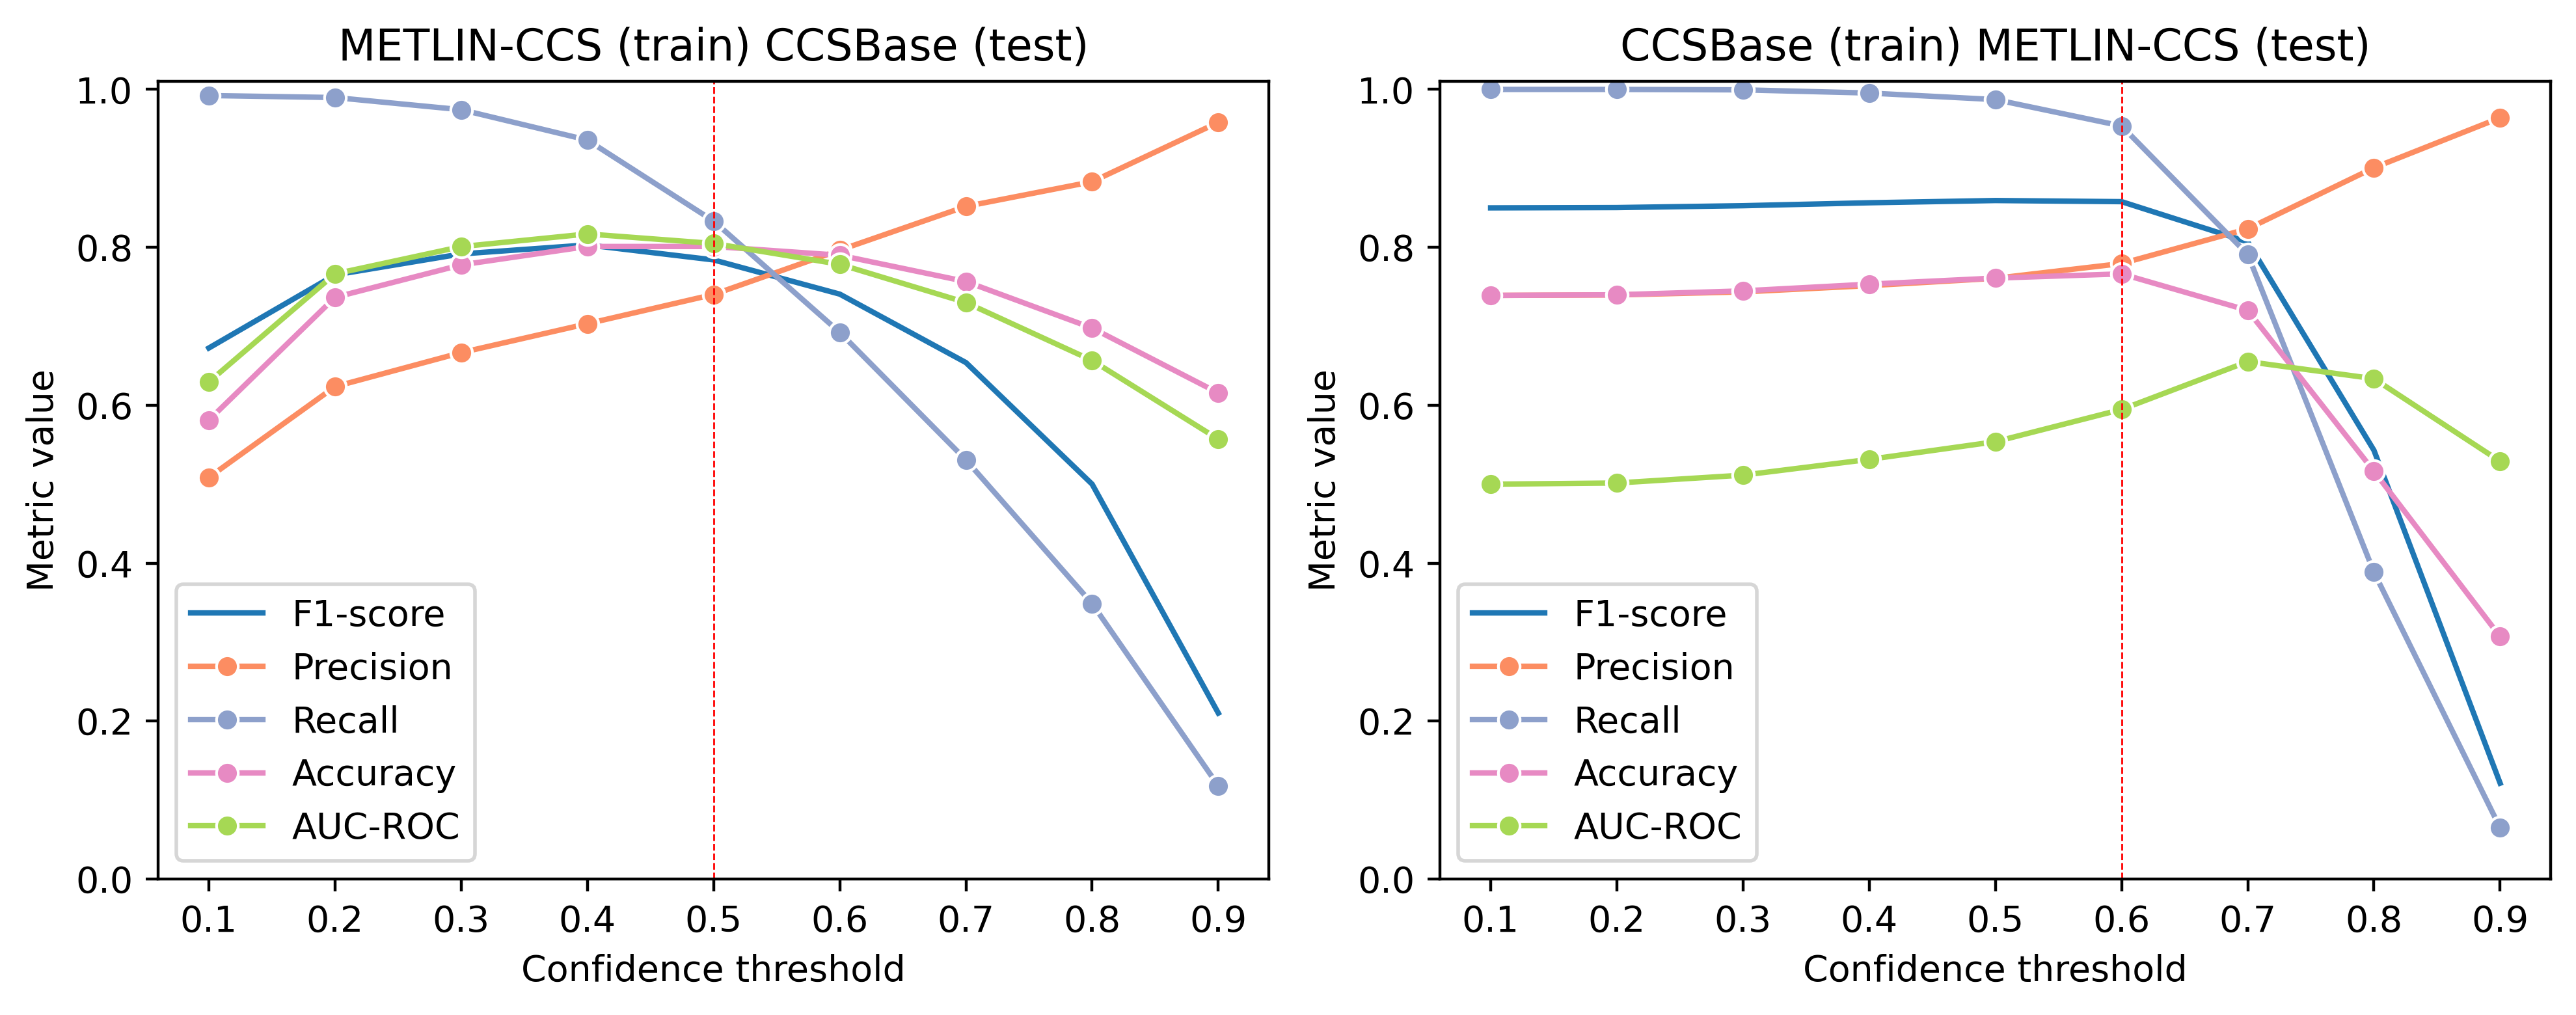

In [21]:
# Plot the metrics for the different thresholds for both datasets

metric_palette = sns.color_palette("Set2")

for num_sample in num_samples:
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=400)
    print(num_sample)
    for i, prediction_file in enumerate(all_cutoffs[num_sample]):
        # if "from" not in prediction_file:
        #     continue

        print(prediction_file)
        cutoffs_df = pd.DataFrame(all_cutoffs[num_sample][prediction_file]).T.iloc[1:]

        sns.lineplot(
            x=cutoffs_df.index,
            y=cutoffs_df["f1"],
            ax=axs[i],
            label="F1-score",
            # # Add points
            # marker="o",
            # color=metric_palette[0],
        )

        sns.lineplot(
            x=cutoffs_df.index,
            y=cutoffs_df["precision"],
            ax=axs[i],
            label="Precision",
            # Add points
            marker="o",
            color=metric_palette[1],
        )

        sns.lineplot(
            x=cutoffs_df.index,
            y=cutoffs_df["recall"],
            ax=axs[i],
            label="Recall",
            # Add points
            marker="o",
            color=metric_palette[2],
        )

        sns.lineplot(
            x=cutoffs_df.index,
            y=cutoffs_df["accuracy"],
            ax=axs[i],
            label="Accuracy",
            # Add points
            marker="o",
            color=metric_palette[3],
        )

        sns.lineplot(
            x=cutoffs_df.index,
            y=cutoffs_df["auc_roc"],
            ax=axs[i],
            label="AUC-ROC",
            # Add points
            marker="o",
            color=metric_palette[4],
        )

        # title
        axs[i].set_title(name_style[prediction_file])
        axs[i].set_xlabel("Confidence threshold")
        axs[i].set_ylabel("Metric value")
        axs[i].set_ylim(0, 1.01)

        # legend
        axs[i].legend()

        # vertical line 0.7
        axs[i].axvline(
            all_thresholds_df[num_sample][prediction_file],
            color="red",
            linestyle="--",
            # tickness
            lw=0.5,
        )

    plt.tight_layout()

    # Save with dpi 400
    plt.savefig("threshold_metrics.png", dpi=400)

    plt.show()

# Let's dive into the high confidence predictions

In [17]:
def calculate_metrics(df):

    mae_original = mean_absolute_error(df["ccs"], df["pred_ccs"])
    rmse_original = mean_squared_error(df["ccs"], df["pred_ccs"])
    r2_original = linregress(df["ccs"], df["pred_ccs"]).rvalue ** 2

    # median relative error in %
    median_relative_error_original = (
        (df["ccs"] - df["pred_ccs"]).abs() / df["ccs"] * 100
    )
    median_relative_error_original = median_relative_error_original.median()

    return mae_original, rmse_original, r2_original, median_relative_error_original

In [18]:
all_high_confidence_preds = {}

all_original_metrics = {}
all_high_confidence_metrics = {}

# Calculate the metrics for the original and high confidence predictions
for num_sample in num_samples:
    high_confidence_preds = {}
    original_metrics = {}
    high_confidence_metrics = {}
    for prediction_file in tqdm(predictions):
        if "from" not in prediction_file:
            continue

        # Get the predictions
        pred_df = all_confidence_preds[num_sample][prediction_file]
        current_threshold = all_thresholds_df[num_sample][prediction_file]

        # Get the high confidence predictions
        high_confidence_preds[prediction_file] = pred_df[
            pred_df["confs"] >= current_threshold
        ]

        # Calculate the metrics for the original predictions
        mae_original, rmse_original, r2_original, median_relative_error_original = (
            calculate_metrics(pred_df)
        )

        # Calculate the metrics for the high confidence predictions
        mae_high, rmse_high, r2_high, median_relative_error_high = calculate_metrics(
            high_confidence_preds[prediction_file]
        )

        # Save the metrics
        original_metrics[prediction_file] = {
            "MAE": mae_original,
            "RMSE": rmse_original,
            "R2": r2_original,
            "MRE": median_relative_error_original,
        }

        high_confidence_metrics[prediction_file] = {
            "MAE": mae_high,
            "RMSE": rmse_high,
            "R2": r2_high,
            "MRE": median_relative_error_high,
        }
    all_high_confidence_preds[num_sample] = high_confidence_preds
    all_original_metrics[num_sample] = original_metrics
    all_high_confidence_metrics[num_sample] = high_confidence_metrics

100%|██████████| 2/2 [00:00<00:00, 245.91it/s]


In [19]:
def plot_scatter(
    pred_df,
    palette,
    title,
    original_metrics,
    high_confidence_metrics,
    legend=False,
    y_label=False,
):

    g = sns.jointplot(
        data=pred_df,
        x=pred_df["ccs"],
        y=pred_df["pred_ccs"],
        hue="adduct",
        palette=palette,
        # add transparency to the points
        alpha=0.4,
        # size of the points
        s=200,
        legend=legend,
    )

    # Add a line to show the perfect correlation
    g.ax_joint.plot(
        [pred_df["ccs"].min(), pred_df["ccs"].max()],
        [pred_df["ccs"].min(), pred_df["ccs"].max()],
        "k--",
        lw=2,
    )

    g.ax_joint.text(
        0.65,
        0.15,
        f"""n={pred_df.shape[0]}
            MAE: {high_confidence_metrics['MAE']:.2f} vs. {original_metrics['MAE']:.2f}
        MRE: {high_confidence_metrics['MRE']:.2f}% vs. {original_metrics['MRE']:.2f}%
        R2: {high_confidence_metrics['R2']:.2f} vs. {original_metrics['R2']:.2f}""",
        horizontalalignment="center",
        verticalalignment="center",
        transform=g.ax_joint.transAxes,
        fontsize=7,
    )

    g.ax_joint.set_xlabel("Experimental CCS", fontweight="bold")

    if y_label:
        g.ax_joint.set_ylabel(f"Predicted CCS", fontweight="bold")
    else:
        g.ax_joint.set_ylabel("")

    # title
    g.ax_joint.set_title(title, y=1.2, fontsize=13)
    plt.setp(g.ax_joint.get_xticklabels(), rotation=0, ha="center", va="top")
    plt.setp(g.ax_joint.get_yticklabels(), rotation=0, ha="right", va="center")
    g.ax_joint.yaxis.set_tick_params(pad=10)
    g.ax_joint.xaxis.set_tick_params(pad=10)

    # set legend title
    if legend:
        g.ax_joint.get_legend().set_title(f"Adduct n={pred_df.shape[0]}")

        g.ax_joint.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=3)

        # legend smaller
        for text in g.ax_joint.get_legend().texts:
            text.set_fontsize(8)

    return g

<Figure size 16000x8000 with 0 Axes>

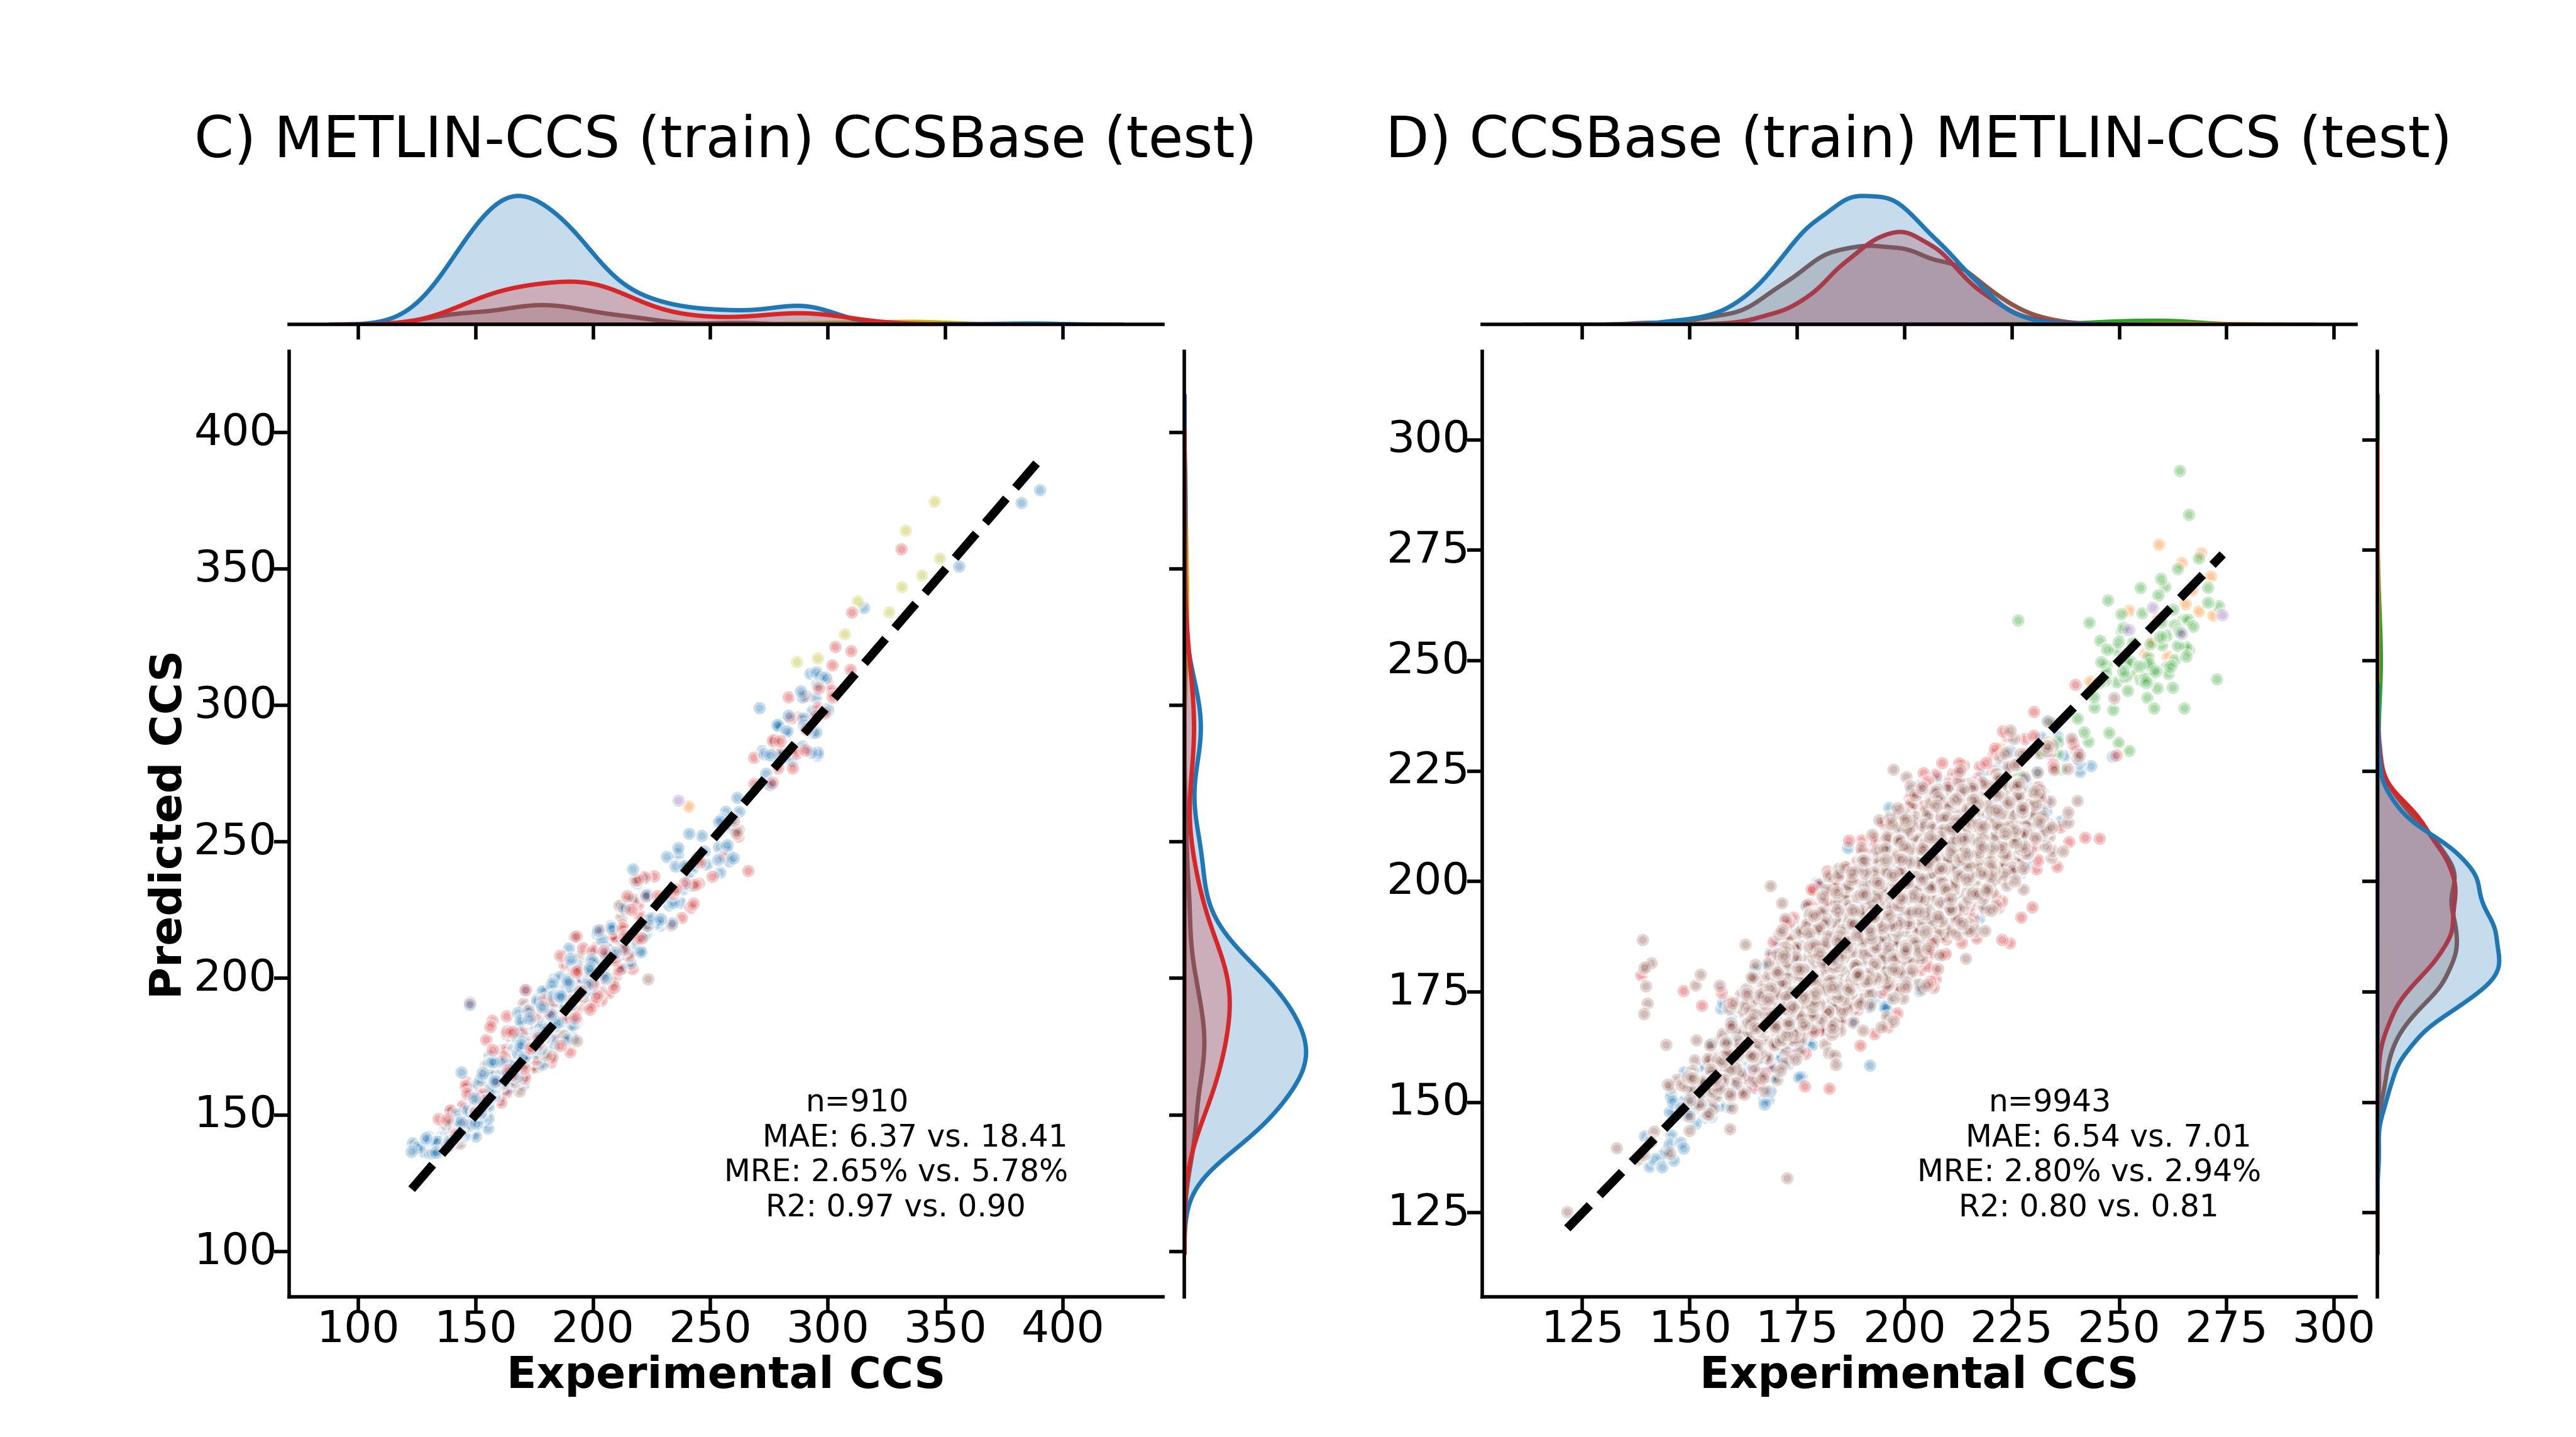

In [20]:
# Plot the distribution of the errors for the high confidence predictions using sns.joinplot

fig = plt.figure(figsize=(40, 20), dpi=400)
gs = gridspec.GridSpec(1, 2)

palette = {
    "[M+H]+": "#1f77b4",
    "[2M+H]+": "#ff7f0e",
    "[M+Na]+": "#d62728",
    "[2M+Na]+": "#2ca02c",
    "[M-H]-": "#8c564b",
    "[2M-H]-": "#9467bd",
    "[M+K]+": "#e377c2",
    "[M+H-H2O]+": "#7f7f7f",
    "[M+NH4]+": "#bcbd22",
}

for num_sample in num_samples:
    fig = plt.figure(figsize=(40, 20), dpi=500)
    gs = gridspec.GridSpec(1, 2)
    for i, prediction_file in enumerate(high_confidence_preds):

        pred_df = all_high_confidence_preds[num_sample][prediction_file]

        if i == 0:
            title = f"C) {name_style[prediction_file]}"
        else:
            title = f"D) {name_style[prediction_file]}"

        SeabornFig2Grid(
            plot_scatter(
                pred_df,
                palette,
                legend=False,  # True if i == 0 else False,
                y_label=True if i == 0 else False,
                title=title,
                original_metrics=all_original_metrics[num_sample][prediction_file],
                high_confidence_metrics=all_high_confidence_metrics[num_sample][
                    prediction_file
                ],
            ),
            fig,
            gs[i],
        )

    plt.tight_layout()
    plt.suptitle(" ", y=0, x=0)
    plt.savefig("figure_5.png", dpi=400)

    plt.show()